![](https://images.pexels.com/photos/2051958/pexels-photo-2051958.jpeg?auto=compress&cs=tinysrgb&h=750&w=1260)

# KITTI 2011 09 28 Raw Data

## Data Sets

Data from [KITTI](http://www.cvlibs.net/datasets/kitti/setup.php). If you go to the [Raw Data page](http://www.cvlibs.net/datasets/kitti/raw_data.php) and download the following data sets (direct links are below, they want to harvest your email address to get the data, **sorry**): 

- [grayscale (400MB)](https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip)
- [calibration (300MB)](https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip)

Note, the video is **big** and why I don't provide a copy of it.

In [1]:
%matplotlib inline 

In [18]:
import cv2          # opencv itself
import numpy as np  # matrix manipulations

import platform
import os

from IPython.display import HTML # need this for embedding a movie in an iframe
from matplotlib import pyplot as plt
import opencvutils
from opencvutils.CameraCalibrate import CameraCalibration

# this is slightly modified
import pykitti

## Sensor Layout

<img src="passat.png" width="50%">

<img src="setup.png" width="85%">

## Video

As shown in the diagram above, there are two sets of cameras: Point Grey Flea 2 (FL-14S3M-C) 1.4 Megapixel grayscale (0 and 1) and Point Grey Flea 2 (FL-14S3C-C) 1.4 Megapixel color (2, 3) cameras. I am just working with the grayscale, rectified, uncompressed (lossless png is what they say).

In [30]:
dataset = pykitti.raw('../do_not_backup', '2011_09_28', '0001', frames=range(100))
print(dir(dataset))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_file_lists', '_load_calib', '_load_calib_cam_to_cam', '_load_calib_rigid', '_load_oxts', '_load_timestamps', 'calib', 'calib_path', 'cam0', 'cam0_files', 'cam1', 'cam1_files', 'cam2', 'cam2_files', 'cam3', 'cam3_files', 'data_path', 'drive', 'frames', 'get_cam0', 'get_cam1', 'get_cam2', 'get_cam3', 'get_gray', 'get_rgb', 'get_velo', 'gray', 'imtype', 'oxts', 'oxts_files', 'rgb', 'timestamps', 'velo', 'velo_files']


In [31]:
def pil2opencv(imgs, hist_equ=False):
    if hist_equ:
        ret = [equalizeHist(np.array(x)) for x in imgs]
    else:
        ret = [np.array(x) for x in imgs]
    return ret

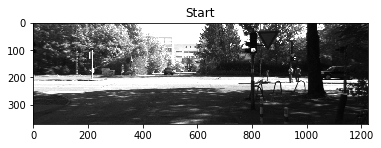

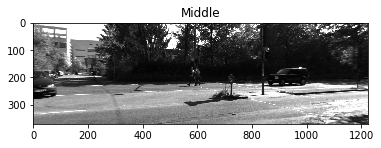

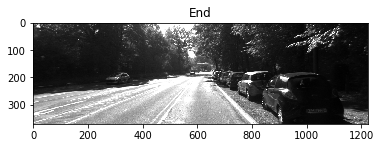

In [32]:
imgs = pil2opencv(dataset.cam0)
plt.figure()
plt.imshow(imgs[0], cmap='gray');
plt.title('Start')
plt.figure()
plt.imshow(imgs[len(imgs)//2], cmap='gray');
plt.title('Middle')
plt.figure()
plt.imshow(imgs[len(imgs)-1], cmap='gray');
plt.title('End');

In [14]:
def videoWrite(frames, fname='out.mp4', fps=30):
    shape = frames[0].shape
    
    frame_height, frame_width = shape[:2]
    
    # video writer doesn't like grayscale images, have
    # to convert to RGB
    if len(shape) == 2:
        grayscale = True
    else:
        grayscale = False
    
    # pick a good encoder for the current OS
    sys = platform.system().lower()
    if sys in ['darwin']:
        fourcc = 'avc1'
    else:
        fourcc = 'mjpg'
    
    print('>> Saving {} {}x{} images to {}'.format(len(imgs), shape[1], shape[0], fname))
    print('>> using {} on {}'.format(fourcc, sys))
    
    # create the video writer and write all frames to the file
    out = cv2.VideoWriter(
        fname,
        cv2.VideoWriter_fourcc(*fourcc), 
        fps, 
        (frame_width,frame_height))
    
    for frame in frames:
        # convert if necessary to RGB
        if grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        out.write(frame)
    
    out.release()
    print('>> wrote {:.1f} MB'.format(os.path.getsize(fname)/(1E6)))

In [19]:
videoWrite(imgs, 'drive.mp4', fps=10)

>> Saving 10 1224x370 images to drive.mp4
>> using avc1 on darwin
>> wrote 0.2 MB


In [20]:
def videoshow(filename, width=None):
    """
    Display a video in a notebook cell
    """
    import io
    import base64
    from IPython.display import HTML
    
    video = io.open(filename, "rb").read()
    video = base64.b64encode(video)
    
    if width:
        fmt = '<video width={} controls src="data:video/mp4;base64,{}" type="video/mp4" />'
        video_tag = fmt.format(width, video.decode("ascii"))
    else:
        fmt = '<video controls src="data:video/mp4;base64,{}" type="video/mp4" />'
        video_tag = fmt.format(video.decode("ascii"))
    return HTML(video_tag)

In [1]:
from ipywidgets import Video
Video.from_file('no-hist-equ-drive.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x1d8\xb0mdat\x00\x…

In [2]:
# applying histogram equalization make more of the details appear
Video.from_file('hist-equ-drive.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x1fK\xd6mdat\x00\x…

## Data Time Stamps

The time stamps come in a couple of different flavors, you will have to look at the data to figure out how to decode it.

In [33]:
stamps = dataset.timestamps

## Inertial Measurement Unit

The car was equiped with the following:

| Models | Position (m) | Velocity (km/h) | Pitch / Roll (deg) | Heading (deg) | Slip angle at 50 km/h (deg) | Dual antenna |
|---|---|---|---|---|---|---|
| RT3003 | 1.5/SPS, 0.6/SBAS, 0.4/DGPS, 0.01/RTK | 0.05 | 0.03 | 0.1 | 0.15 | Yes |

- [link](https://www.oxts.com/products/rt3000/)
- [datasheet](rt3000.pdf)

In [34]:
# oxts = get_oxts('./2011_09_28_drive_0001_sync/oxts/data/*.txt')
oxts = dataset.oxts

In [35]:
# let's look at the first data sample, they use namedtuples,
# so the parameters are named so you know what they are. Now,
# there are some flags at the end that I don't know what they
# are ... they do a poor job of describing the setup in ONE place.
# I am sure if I scoured the internet, I could find the info.
print('Raw Data Packet:\n')
print(oxts[0].packet)
print('-'*50)
print('Homogeneous Transform starting from the origin:\n')
print(oxts[0].T_w_imu)

Raw Data Packet:

OxtsPacket(lat=49.01516951632, lon=8.4180554580103, alt=115.0393371582, roll=-0.000783, pitch=0.012216, yaw=0.060646326794897, vn=0.00074566578756374, ve=0.14446958380423, vf=0.14424991235443, vl=0.0079996352068067, vu=-0.00055422749427742, ax=0.2194919499829, ay=-0.017258291248084, az=9.8390245983713, af=0.3395380735984, al=-0.0089211113720565, au=9.8356245212723, wx=0.0013822352203865, wy=0.000225307387896, wz=0.0017816754417577, wf=0.0014038852176763, wl=0.0002267415878623, wu=0.00176455835955, pos_accuracy=0.078517513969814, vel_accuracy=0.010630145812735, navstat=4, numsats=11, posmode=6, velmode=6, orimode=6)
--------------------------------------------------
Homogeneous Transform starting from the origin:

[[ 9.98087098e-01 -6.06186864e-02  1.21457778e-02  0.00000000e+00]
 [ 6.06046353e-02  9.98160689e-01  1.52194326e-03  0.00000000e+00]
 [-1.22156962e-02 -7.82941497e-04  9.99925079e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000

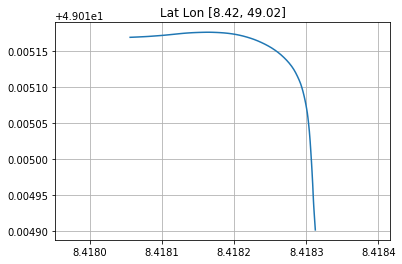

In [36]:
y = [x.packet.lat for x in oxts]
x = [x.packet.lon for x in oxts]
plt.plot(x,y)
plt.grid(True)
plt.axis('equal')
plt.title('Lat Lon [{:.2f}, {:.2f}]'.format(oxts[0].packet.lon, oxts[0].packet.lat));

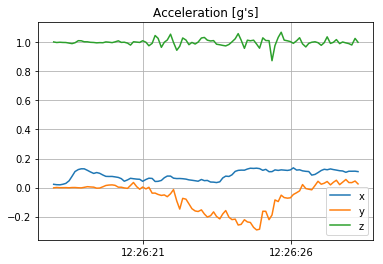

In [37]:
x = [x.packet.ax/9.81 for x in oxts]
y = [x.packet.ay/9.81 for x in oxts]
z = [x.packet.az/9.81 for x in oxts]
plt.plot(stamps, x, label='x')
plt.plot(stamps, y, label='y')
plt.plot(stamps, z, label='z')
plt.grid(True)
plt.legend()
plt.title('Acceleration [g\'s]');

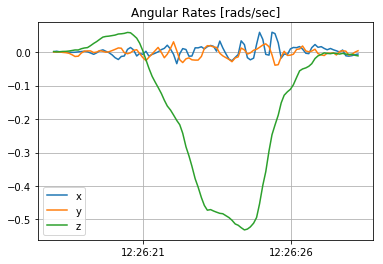

In [38]:
x = [x.packet.wx for x in oxts]
y = [x.packet.wy for x in oxts]
z = [x.packet.wz for x in oxts]
plt.plot(stamps, x, label='x')
plt.plot(stamps, y, label='y')
plt.plot(stamps, z, label='z')
plt.grid(True)
plt.legend()
plt.title('Angular Rates [rads/sec]');